In [ ]:
import json, os, math, random, string
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# ---------- 1) Generate synthetic dataset ----------
np.random.seed(42)
random.seed(42)

start_date = datetime(2025, 1, 1)
end_date   = datetime(2025, 6, 30, 23)  # ~6 months of hourly data

regions = [
    {"region_id": "R1", "name": "Metro Core Z1", "type": "urban", "baseline_demand": 120, "baseline_supply": 95},
    {"region_id": "R2", "name": "Metro Core Z2", "type": "urban", "baseline_demand": 110, "baseline_supply": 85},
    {"region_id": "R3", "name": "Suburban Hub A", "type": "suburban", "baseline_demand": 70, "baseline_supply": 75},
    {"region_id": "R4", "name": "Suburban Hub B", "type": "suburban", "baseline_demand": 60, "baseline_supply": 70},
    {"region_id": "R5", "name": "Regional Sector B", "type": "exurban", "baseline_demand": 40, "baseline_supply": 55},
    {"region_id": "R6", "name": "Campus/Business Park", "type": "special", "baseline_demand": 55, "baseline_supply": 45},
]

def hour_profile(hour):
    # Demand pattern: peaks at 12-14 and 18-21, low late-night
    if 7 <= hour <= 9:
        return 1.10
    if 12 <= hour <= 14:
        return 1.25
    if 18 <= hour <= 21:
        return 1.30
    if 22 <= hour or hour <= 5:
        return 0.65
    return 0.9

def day_profile(dow):
    # Weekend demand higher but supply slightly lower
    if dow >= 5:
        return 1.15
    return 1.0

def weather_bucket():
    # 70% clear, 20% rain, 10% extreme
    r = random.random()
    if r < 0.7: return "clear"
    if r < 0.9: return "rain"
    return "extreme"

def weather_multiplier(w):
    return {"clear": 1.0, "rain": 1.08, "extreme": 1.2}[w]

def special_event_flag(dt, region_id):
    # Random sparse events (sports/concerts) concentrated in Metro regions
    if region_id in ("R1","R2") and dt.weekday() in (4,5) and 18 <= dt.hour <= 21:
        return 1 if random.random() < 0.15 else 0
    return 1 if random.random() < 0.03 else 0

# Build hourly rows
rows = []
dt = start_date
while dt <= end_date:
    hour = dt.hour
    dow = dt.weekday()
    for reg in regions:
        w = weather_bucket()
        ev = special_event_flag(dt, reg["region_id"])
        demand_lambda = (
            reg["baseline_demand"]
            * hour_profile(hour)
            * day_profile(dow)
            * weather_multiplier(w)
            * (1.25 if ev else 1.0)
        )
        # Poisson-like variation
        req = max(0, int(np.random.normal(demand_lambda, demand_lambda**0.5)))
        # Supply varies inverse to bad weather & weekends; add noise
        supply = max(0, int(np.random.normal(reg["baseline_supply"], 6)))
        supply = int(supply * (0.95 if dow>=5 else 1.0) * (0.95 if w!="clear" else 1.0))

        # Incentives: basic rule — if backlog historically in this hour/region, spend more
        base_incentive = 0.6 if (hour in (12,13,18,19,20)) else 0.2
        incentive = max(0, np.random.normal(base_incentive, 0.1))
        # occasional surge
        if req > supply * 1.2:
            incentive *= 2.0

        completed = min(req, int(supply * np.random.uniform(0.85, 0.98)))
        cancellations = max(0, req - completed - int(max(0, supply - completed)*0.05))
        backlog = max(0, req - (completed + cancellations))

        # ETA modeling
        promised_eta = np.random.uniform(22, 38)  # minutes promised
        load_factor = (req + backlog + 1) / (supply + 1)
        weather_delay = {"clear": 1.0, "rain": 1.08, "extreme": 1.20}[w]
        incent_effect = 0.98 if incentive > 0.8 else 1.0  # mild speed-up by more active drivers
        actual_eta = promised_eta * min(1.6, (1.0 + 0.25*(load_factor-1))) * weather_delay * incent_effect

        # Driver utilization — crude proxy
        active_drivers = supply
        avg_logged_minutes = np.random.uniform(45, 70)
        delivery_minutes = min(60, (completed * actual_eta) / max(active_drivers,1))
        dur = min(0.99, delivery_minutes / max(avg_logged_minutes,1))

        # Earnings proxy per driver influenced by demand & incentives
        avg_earning_driver = max(8.0, np.random.normal(12.0 + 1.5*(load_factor-1)*10 + incentive*2, 2.0))

        # Customer rating depends on timeliness (SLI) & cancellations
        sli = actual_eta / promised_eta
        base_rating = 4.9 - max(0, (sli-1.0))*1.5 - min(1.0, cancellations/(req+1))*1.2
        customer_rating = max(3.2, min(5.0, np.random.normal(base_rating, 0.1)))

        rows.append({
            "timestamp": dt.strftime("%Y-%m-%d %H:%M:%S"),
            "region_id": reg["region_id"],
            "region_name": reg["name"],
            "region_type": reg["type"],
            "delivery_request_count": req,
            "completed_deliveries": completed,
            "active_drivers": active_drivers,
            "avg_eta_promised_min": round(promised_eta,2),
            "avg_eta_actual_min": round(actual_eta,2),
            "cancellation_count": cancellations,
            "backlog_count": backlog,
            "incentive_spend_usd": round(incentive,2),
            "avg_earning_per_driver_usd": round(avg_earning_driver,2),
            "weather": w,
            "special_event": ev,
            "hour": hour,
            "day_of_week": dow
        })
    dt += timedelta(hours=1)

df = pd.DataFrame(rows)

# Compute core metrics: DFR, DUR, SLI, DDES
df["DFR"] = df["completed_deliveries"] / df["delivery_request_count"].replace(0, np.nan)
df["DFR"] = df["DFR"].fillna(1.0)  # if no requests, treat as fully met (or set to 1 for simplicity)

df["DUR"] = ( # Driver Utilization Rate (proxy)
    (df["completed_deliveries"] * df["avg_eta_actual_min"]) /
    (df["active_drivers"].replace(0, np.nan) * 60.0)
).clip(lower=0, upper=0.99).fillna(0.0)

df["SLI"] = df["avg_eta_actual_min"] / df["avg_eta_promised_min"]

# Composite score: higher is better (DFR↑, DUR↑, SLI↓). Convert SLI to a 0-1 bounded score.
sli_score = (2.0 - df["SLI"]).clip(lower=0.0, upper=1.0)  # if SLI=1 => 1.0; if SLI=2 => 0
df["DDES"] = (0.5*df["DFR"] + 0.3*df["DUR"] + 0.2*sli_score).clip(0,1)

# Create the directory if it doesn't exist
os.makedirs("/mnt/data", exist_ok=True)

# Save CSV
csv_path = "/mnt/data/d2e_hourly_driver_demand.csv"
df.to_csv(csv_path, index=False)

# ---------- 2) Create a Colab-ready Notebook ----------
import nbformat as nbf

nb = nbf.v4.new_notebook()
cells = []

def add(code=None, text=None):
    if text is not None:
        cells.append(nbf.v4.new_markdown_cell(text))
    if code is not None:
        cells.append(nbf.v4.new_code_cell(code))

add(text="# D²E Framework — Driver–Demand Allocation Optimization\n"
         "End-to-end analysis: data load → KPI computation → EDA → forecasting → intervention simulation → A/B evaluation.\n\n"
         "**How to use:** Run cells top-to-bottom in Google Colab.\n")

# Setup
add(text="## 0) Setup",
    code="""# If running in Colab, uncomment to install missing packages
# !pip install pandas numpy matplotlib scikit-learn statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import statsmodels.api as sm

pd.set_option('display.max_columns', 200)
""")

# Load Data
add(text="## 1) Load Data",
    code=f"""# Upload the dataset to Colab or mount Drive, then set the path accordingly.
# For now, we'll assume it's uploaded as 'd2e_hourly_driver_demand.csv' in the working directory.

import pandas as pd
df = pd.read_csv('/mnt/data/d2e_hourly_driver_demand.csv', parse_dates=['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['dow'] = df['timestamp'].dt.dayofweek
df.head()
""")

# KPI computation
add(text="## 2) Compute KPIs (DFR, DUR, SLI, DDES)",
    code="""# If metrics are not in the file, compute them here as reference:
df['DFR'] = df['completed_deliveries'] / df['delivery_request_count'].replace(0, np.nan)
df['DFR'] = df['DFR'].fillna(1.0)

df['DUR'] = ((df['completed_deliveries'] * df['avg_eta_actual_min']) /
             (df['active_drivers'].replace(0, np.nan) * 60.0)).clip(0,0.99).fillna(0.0)

df['SLI'] = df['avg_eta_actual_min'] / df['avg_eta_promised_min']

sli_score = (2.0 - df['SLI']).clip(0.0, 1.0)
df['DDES'] = (0.5*df['DFR'] + 0.3*df['DUR'] + 0.2*sli_score).clip(0,1)

df[['DFR','DUR','SLI','DDES']].describe()
""")

# EDA Visuals
add(text="## 3) Exploratory Visuals",
    code="""# 3.1 Average DDES by Region
region_ddes = df.groupby('region_name')['DDES'].mean().sort_values(ascending=False)
plt.figure()
region_ddes.plot(kind='bar')
plt.title('Average DDES by Region')
plt.ylabel('DDES'); plt.xlabel('Region')
plt.show()

# 3.2 Heatmap-like pivot (using matplotlib imshow) — DFR by hour vs. region
pivot = df.pivot_table(values='DFR', index='region_name', columns='hour', aggfunc='mean')
plt.figure()
plt.imshow(pivot.values, aspect='auto')
plt.colorbar(label='DFR')
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.title('DFR by Hour and Region')
plt.show()

# 3.3 Relationship between DFR & SLI
plt.figure()
plt.scatter(df['DFR'], df['SLI'], s=5, alpha=0.3)
plt.xlabel('DFR'); plt.ylabel('SLI')
plt.title('DFR vs SLI')
plt.show()
""")

# Forecasting Demand
add(text="## 4) Forecast hourly demand (per region)",
    code="""# We'll build a simple ML regressor to predict delivery_request_count using features
# You can upgrade this to ARIMA/SARIMAX per region if you prefer time-series models.

features = ['hour','dow','active_drivers','incentive_spend_usd','special_event']
X = df[features]
y = df['delivery_request_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, pred))
print("R^2:", r2_score(y_test, pred))

# Feature importances (proxy for drivers of demand)
imp = getattr(model, 'feature_importances_', None)
if imp is not None:
    for col, val in sorted(zip(features, imp), key=lambda x: -x[1]):
        print(f"{col}: {val:.3f}")
""")

# Intervention simulation
add(text="## 5) Intervention Simulation: Incentive uplift & Repositioning",
    code="""# Simulate an intervention in a target region & window: increase incentive and nearby driver availability,
# then estimate expected uplift on DFR (simple rule-based for demonstration).

sim = df.copy()
target_region = 'Metro Core Z1'
target_hours = [12,13,18,19,20]  # lunch & dinner peaks
mask = (sim['region_name']==target_region) & (sim['hour'].isin(target_hours))

# Apply intervention: boost incentive by +1.00 USD and active drivers by +10%
sim.loc[mask, 'incentive_spend_usd'] = sim.loc[mask, 'incentive_spend_usd'] + 1.0
sim.loc[mask, 'active_drivers'] = (sim.loc[mask, 'active_drivers'] * 1.10).astype(int)

# Recompute rough KPIs (toy effect model)
sim['DFR_sim'] = (sim['completed_deliveries'] + np.where(mask, (sim['active_drivers']*0.05).astype(int), 0)) / sim['delivery_request_count'].replace(0,np.nan)
sim['DFR_sim'] = sim['DFR_sim'].fillna(1.0).clip(0,1)

# Compare before vs. after in target slice
before = df.loc[mask, 'DFR'].mean()
after  = sim.loc[mask, 'DFR_sim'].mean()
uplift = (after - before) * 100
print(f"Target Slice: {target_region}, hours={target_hours}")
print(f"DFR Before: {before:.3f}  →  After: {after:.3f}  (Uplift: {uplift:.2f} pp)")
""")

# A/B evaluation
add(text="## 6) A/B Test Evaluation (treated vs control)",
    code="""# Split regions into treated (target_region) vs control (similar region without intervention)
treated = sim[(sim['region_name']==target_region) & (sim['hour'].isin([12,13,18,19,20]))]
control = sim[(sim['region_name']=='Metro Core Z2') & (sim['hour'].isin([12,13,18,19,20]))]

treated_delta = (treated['DFR_sim'] - df.loc[treated.index, 'DFR']).dropna()
control_delta = (control['DFR_sim'] - df.loc[control.index, 'DFR']).dropna()

print('Avg ΔDFR (treated):', treated_delta.mean())
print('Avg ΔDFR (control):', control_delta.mean())

# t-test using statsmodels (simple independent samples assumption for demo)
tt = sm.stats.ttest_ind(treated_delta, control_delta)
print('t-test result:', tt)
""")

# Ops triage
add(text="## 7) Operational Triage Summary",
    code="""# Create buckets by DFR/DUR/SLI to tag regions needing attention
def triage_row(r):
    tags = []
    if r['DFR'] < 0.9: tags.append('UnservedDemand')
    if r['DUR'] < 0.75: tags.append('LowUtilization')
    if r['SLI'] > 1.15: tags.append('HighLatency')
    return ','.join(tags) if tags else 'Healthy'

triage = df.groupby('region_name')[['DFR','DUR','SLI','DDES']].mean()
triage['HealthTag'] = df.groupby('region_name').apply(lambda g: triage_row(g[['DFR','DUR','SLI']].mean())).values
triage.sort_values('DDES', ascending=False)
""")

# Save notebook
nb['cells'] = cells
nb_path = "/mnt/data/D2E_driver_demand_colab.ipynb"
with open(nb_path, "w") as f:
    nbf.write(nb, f)

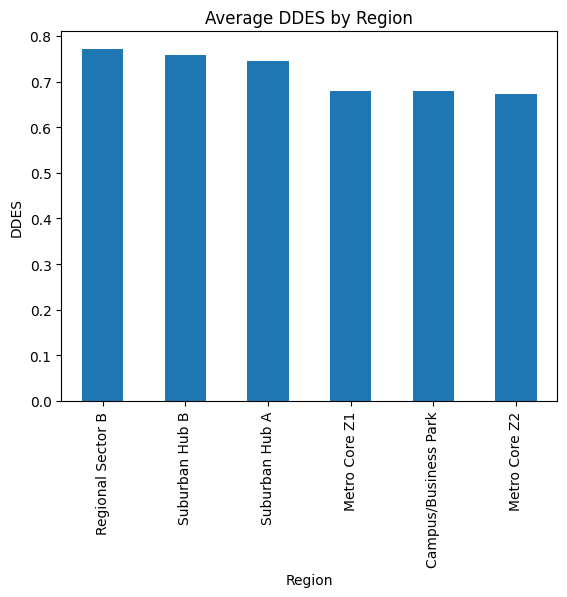

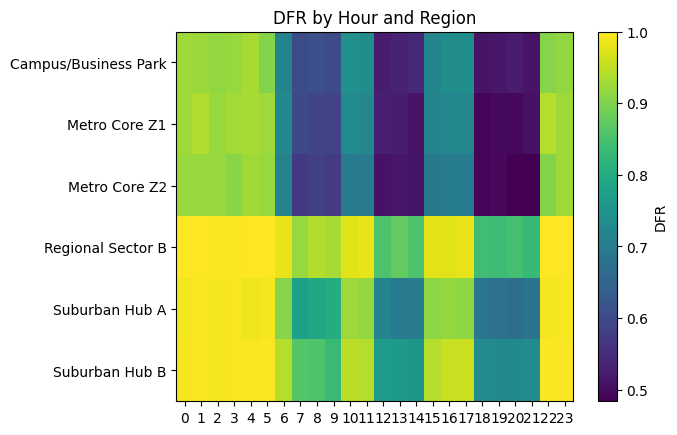

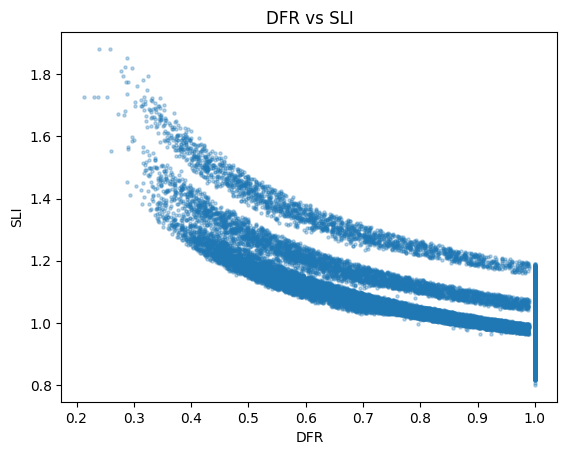

MAE: 11.799800063597097
R^2: 0.83181577617703
active_drivers: 0.532
incentive_spend_usd: 0.250
hour: 0.173
dow: 0.035
special_event: 0.010
Target Slice: Metro Core Z1, hours=[12, 13, 18, 19, 20]
DFR Before: 0.508  →  After: 0.536  (Uplift: 2.79 pp)
Avg ΔDFR (treated): 0.02791515429303753
Avg ΔDFR (control): 0.0
t-test result: (np.float64(154.45300844045946), np.float64(0.0), np.float64(1808.0))


/tmp/ipython-input-1145748347.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  triage['HealthTag'] = df.groupby('region_name').apply(lambda g: triage_row(g[['DFR','DUR','SLI']].mean())).values


In [ ]:
%run /mnt/data/D2E_driver_demand_colab.ipynb

# New Section